In [1]:
%load_ext autoreload
%autoreload 2
from alphatoe import models, plot, interpretability, game
import pandas as pd
import torch
from pytorch_memlab import LineProfiler, MemReporter
from showmethetypes import SMTT
import einops
import matplotlib.pyplot as plt
from matplotlib.ticker import LogFormatter
import numpy as np
import tqdm
import random

In [2]:
autoenc = torch.load('./sparse_autoencoder_on_activations_07NOV2023.pt')
act_data = torch.load('./all_games_act_data.pt')

In [3]:
@torch.no_grad()
def get_freqs(num_batches=25, local_encoder=None):
    if local_encoder is None:
        local_encoder = encoder
    act_freq_scores = torch.zeros(
        local_encoder.W_in.shape[1], dtype=torch.float32
    ).cuda()
    total = 0
    for i in tqdm.trange(num_batches):
        tokens = act_data[torch.randperm(len(act_data))][: 2**14].to("cuda")

        hidden = local_encoder.get_act_density(tokens)

        act_freq_scores += hidden   
        total += tokens.shape[0]
    act_freq_scores /= total
    num_dead = (act_freq_scores == 0).float().mean()
    print("Num dead", num_dead)
    return act_freq_scores

In [4]:
freqs = get_freqs(local_encoder=autoenc)

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:20<00:00,  1.24it/s]

Num dead tensor(0.1621, device='cuda:0')


In [3]:
model = interpretability.load_model(
    "../scripts/models/prob all 8 layer control-20230718-185339"
)

In [4]:
def neuron_posembed_activations(seq):
    def hook(module, input, output):
        result = output.clone()
        module.captured_activations = result

    try:
        handle = model.blocks[0].mlp.hook_post.register_forward_hook(hook)
        _ = model.blocks[0].mlp(seq)
        activations = model.blocks[0].mlp.hook_post.captured_activations
        handle.remove()
    except Exception as e:
        handle.remove()
        raise e

    return activations


def neuron_activations(seq):
    def hook(module, input, output):
        result = output.clone()
        module.captured_activations = result

    try:
        handle = model.blocks[0].mlp.hook_post.register_forward_hook(hook)
        _ = model(seq)
        activations = model.blocks[0].mlp.hook_post.captured_activations
        handle.remove()
    except Exception as e:
        handle.remove()
        raise e

    return activations

In [5]:
games = pd.read_csv("../data/prob all 8 layer control-20230718-185339_stats.csv")
games.head()

/tmp/ipykernel_1198996/629368561.py:1: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  games = pd.read_csv("../data/prob all 8 layer control-20230718-185339_stats.csv")


,moves played,steps till end state,winner,rotation 1,rotation 2,rotation 3,horizontal flip,vertical flip,training index,train or test,first win condition,second win condition,end move loss
0,"[0, 1, 3, 2, 6]",5,X,399,1439,1040,1114,325,241912,test,left column,NaN,0.000005
1,"[0, 1, 3, 4, 6]",5,X,396,1438,1043,1112,327,190522,train,left column,NaN,0.000114
2,"[0, 1, 3, 5, 6]",5,X,398,1437,1041,1113,326,90275,train,left column,NaN,0.000007
3,"[0, 1, 3, 7, 6]",5,X,395,1436,1044,1110,329,21994,train,left column,NaN,0.000008
4,"[0, 1, 3, 8, 6]",5,X,397,1435,1042,1111,328,48696,train,left column,NaN,0.000013


In [6]:
end_game_types = list(games["first win condition"].unique())
print(end_game_types)

['left column', 'top left -> bottom right', 'top row', 'middle column', 'bottom left -> top right', 'right column', 'middle row', 'bottom row', nan]


In [7]:
non_9_move_games = games[games["steps till end state"] != 9]

In [8]:
# game_types x game x moves
game_kinds = [
    [
        [10] + eval(move)
        for move in non_9_move_games[
            non_9_move_games["first win condition"] == game_type
        ]["moves played"]
    ]
    for game_type in end_game_types[:-1]
]

In [9]:
# 30 seconds
game_count = 1_000
all_activations = []
for games in game_kinds:
    kind_activations = []
    for _ in range(game_count):
        data = torch.tensor(random.choice(games))
        kind_activations.append(neuron_activations(data)[0][-1])
    all_activations.append(torch.stack(kind_activations))
all_activations = torch.cat(all_activations)
all_activations = all_activations.detach().cpu().T

<Figure size 720x720 with 0 Axes>

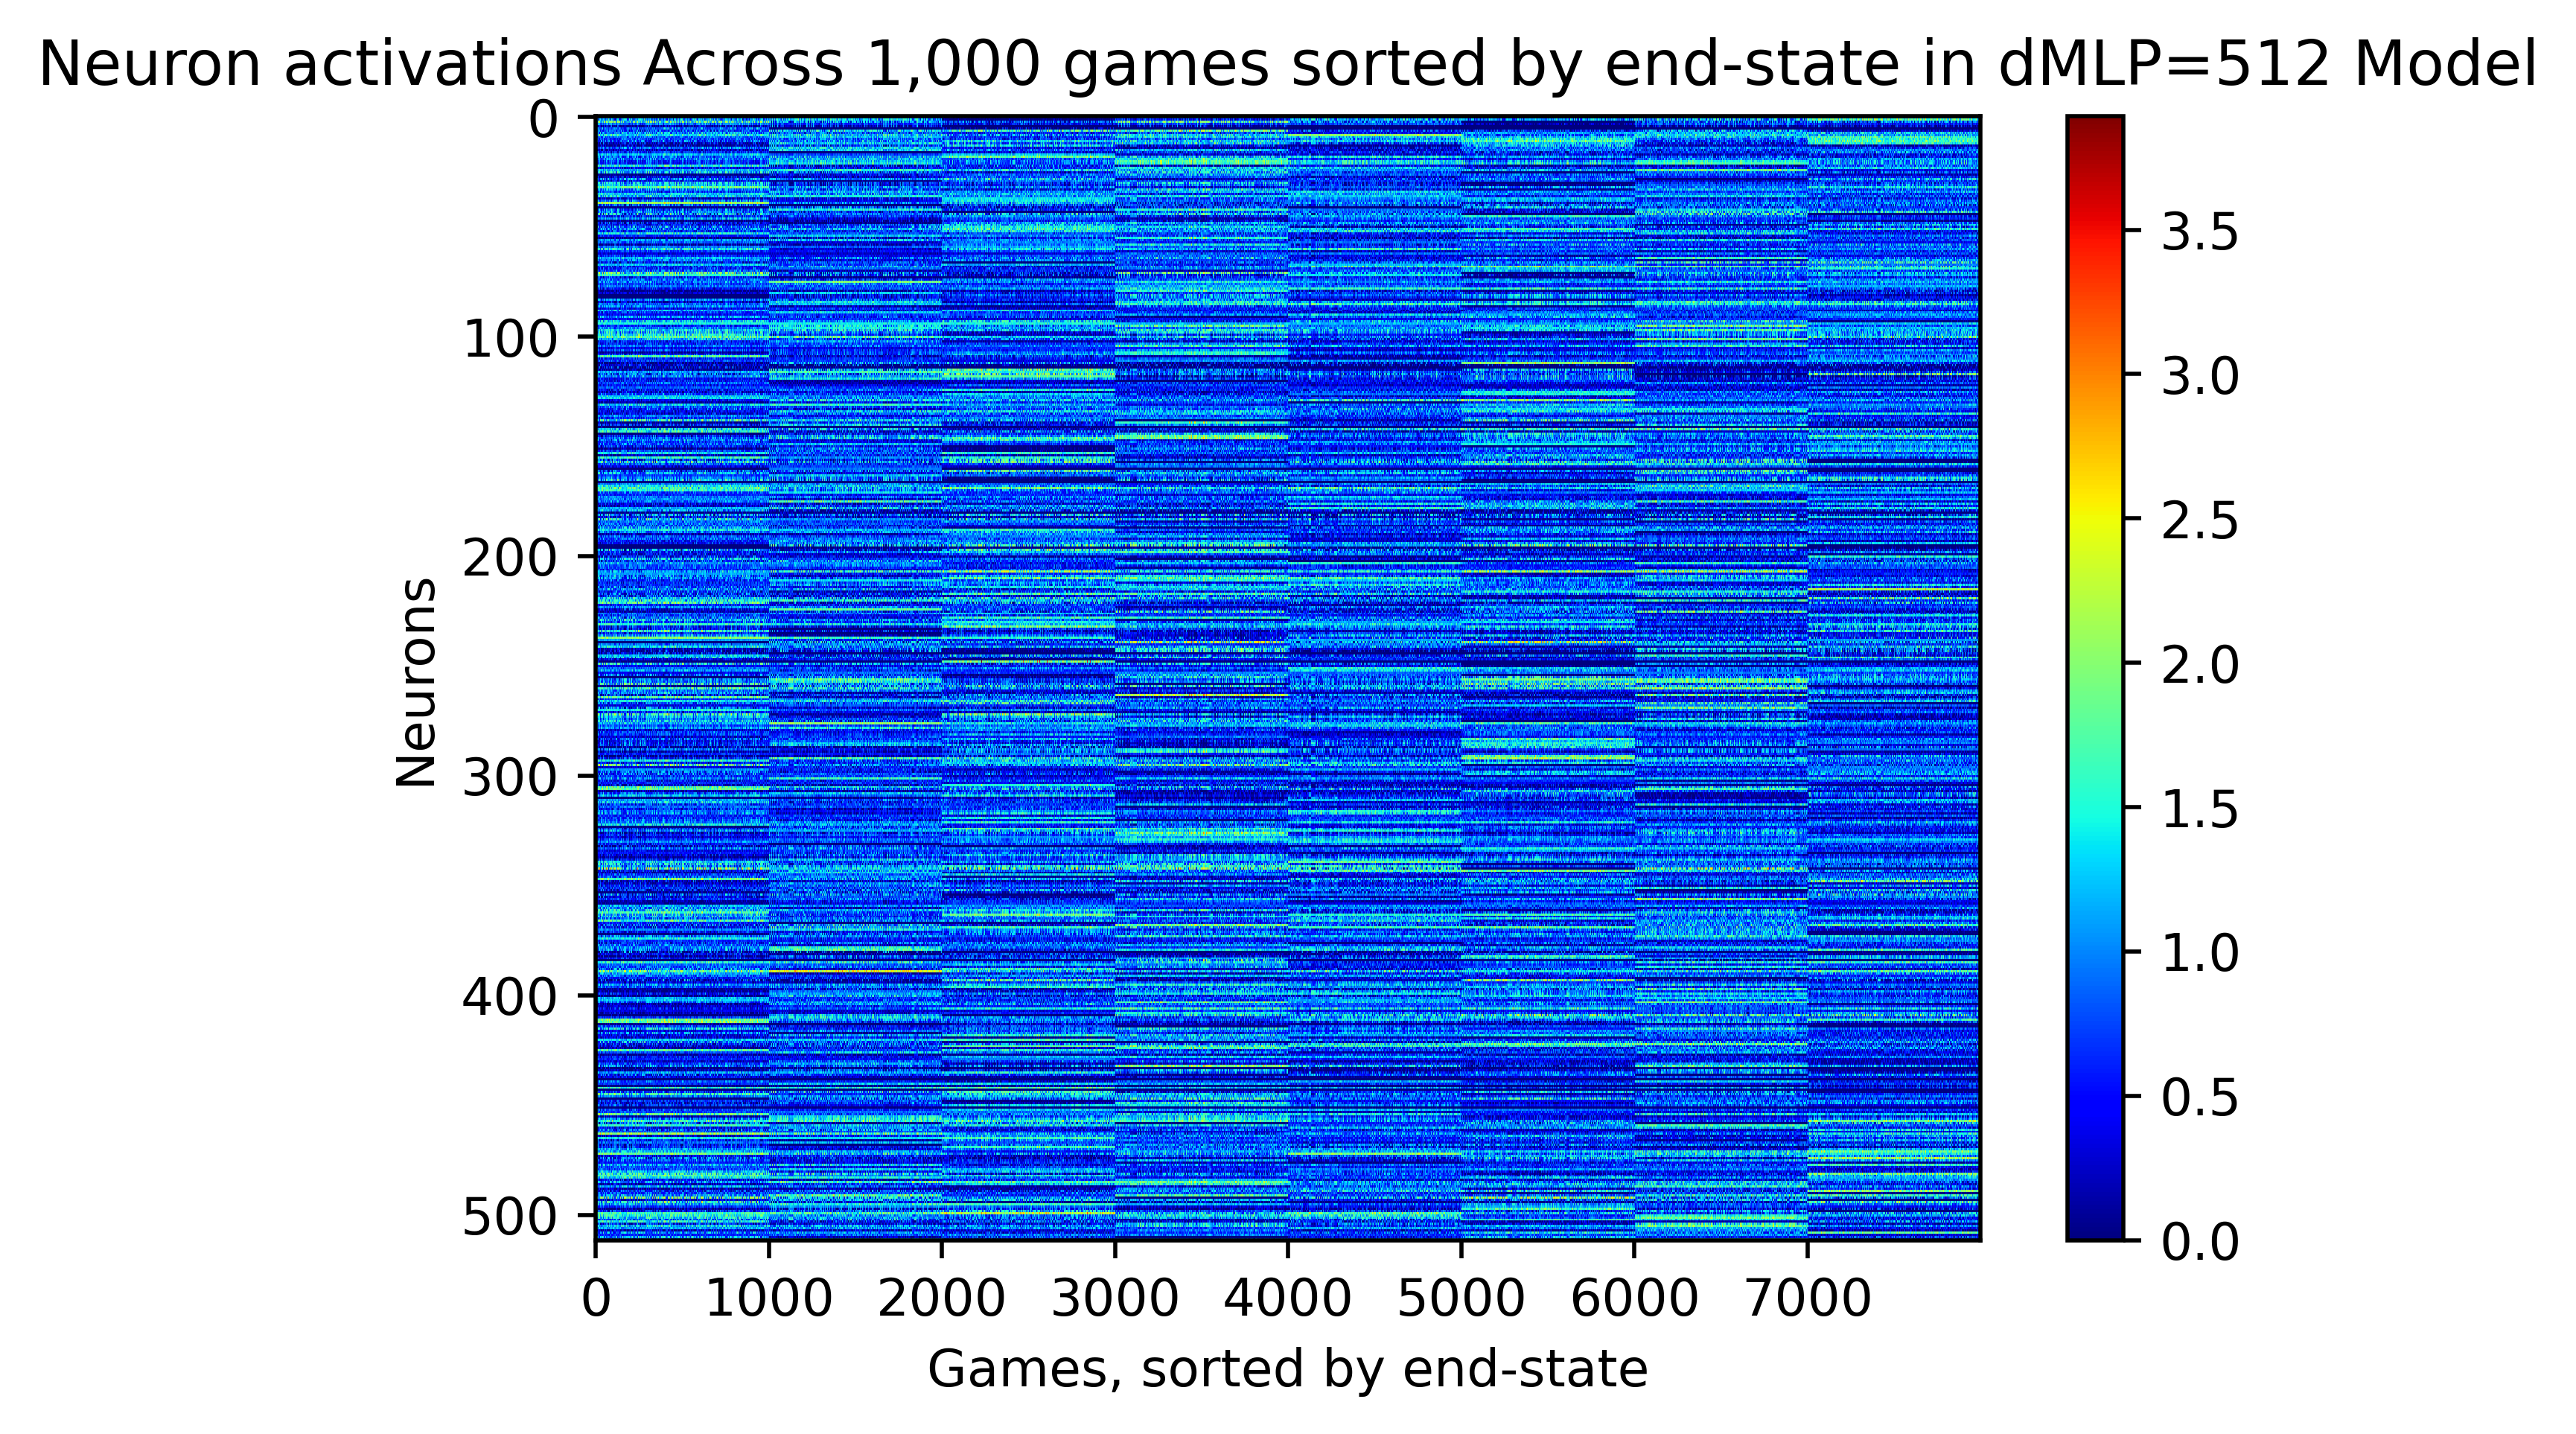

In [10]:
plt.figure(figsize=(10, 10))
# dpi
plt.figure(dpi=500)
plt.imshow(all_activations, cmap="jet", aspect="auto", interpolation="none")
# colorbar
plt.colorbar()

plt.xlabel("Games, sorted by end-state")

plt.ylabel("Neurons")
# title
plt.title(
    "Neuron activations Across 1,000 games sorted by end-state in dMLP=512 Model",
    fontsize=12,
)
plt.gcf().set_facecolor("white")

In [11]:
all_activations = all_activations.T

In [15]:
torch.save(autoenc.state_dict(), "./sparse_autoencoder_on_activations_07NOV2023_parameters.pt")

In [16]:
autoenc_cool = models.SparseAutoEncoder(512, 1024).cuda()

In [17]:
autoenc_cool.load_state_dict(torch.load("./sparse_autoencoder_on_activations_07NOV2023_parameters.pt"))

<All keys matched successfully>

In [18]:
all_activations.to('cuda')

tensor([[1.0722, 1.2883, 2.0580,  ..., 0.3725, 0.8673, 0.8023],
        [1.0145, 1.3561, 1.1237,  ..., 0.4441, 1.3068, 1.1824],
        [1.0611, 0.6999, 2.0449,  ..., 0.5320, 0.9609, 0.9678],
        ...,
        [0.4567, 2.1772, 0.8640,  ..., 0.1647, 0.0893, 0.9271],
        [0.0000, 1.4919, 0.0000,  ..., 0.2910, 1.0475, 0.1759],
        [0.4963, 1.7205, 1.5188,  ..., 0.2614, 0.5633, 0.4557]],
       device='cuda:0')

In [19]:
all_features = torch.stack([
    autoenc_cool.get_activations(activation.to('cuda')) for activation in tqdm.tqdm(all_activations)
])

  0%|          | 0/8000 [00:00<?, ?it/s]

100%|██████████| 8000/8000 [00:00<00:00, 9986.26it/s] 


In [26]:
tt = SMTT("torch")

In [29]:
tt(all_features)

Tensor (dtype: torch.float32)
    |  (device: cuda:0)
    |__dim_0 (8000)
    |__dim_1 (1024)


In [20]:
all_features = all_features.detach().cpu().T

<Figure size 720x720 with 0 Axes>

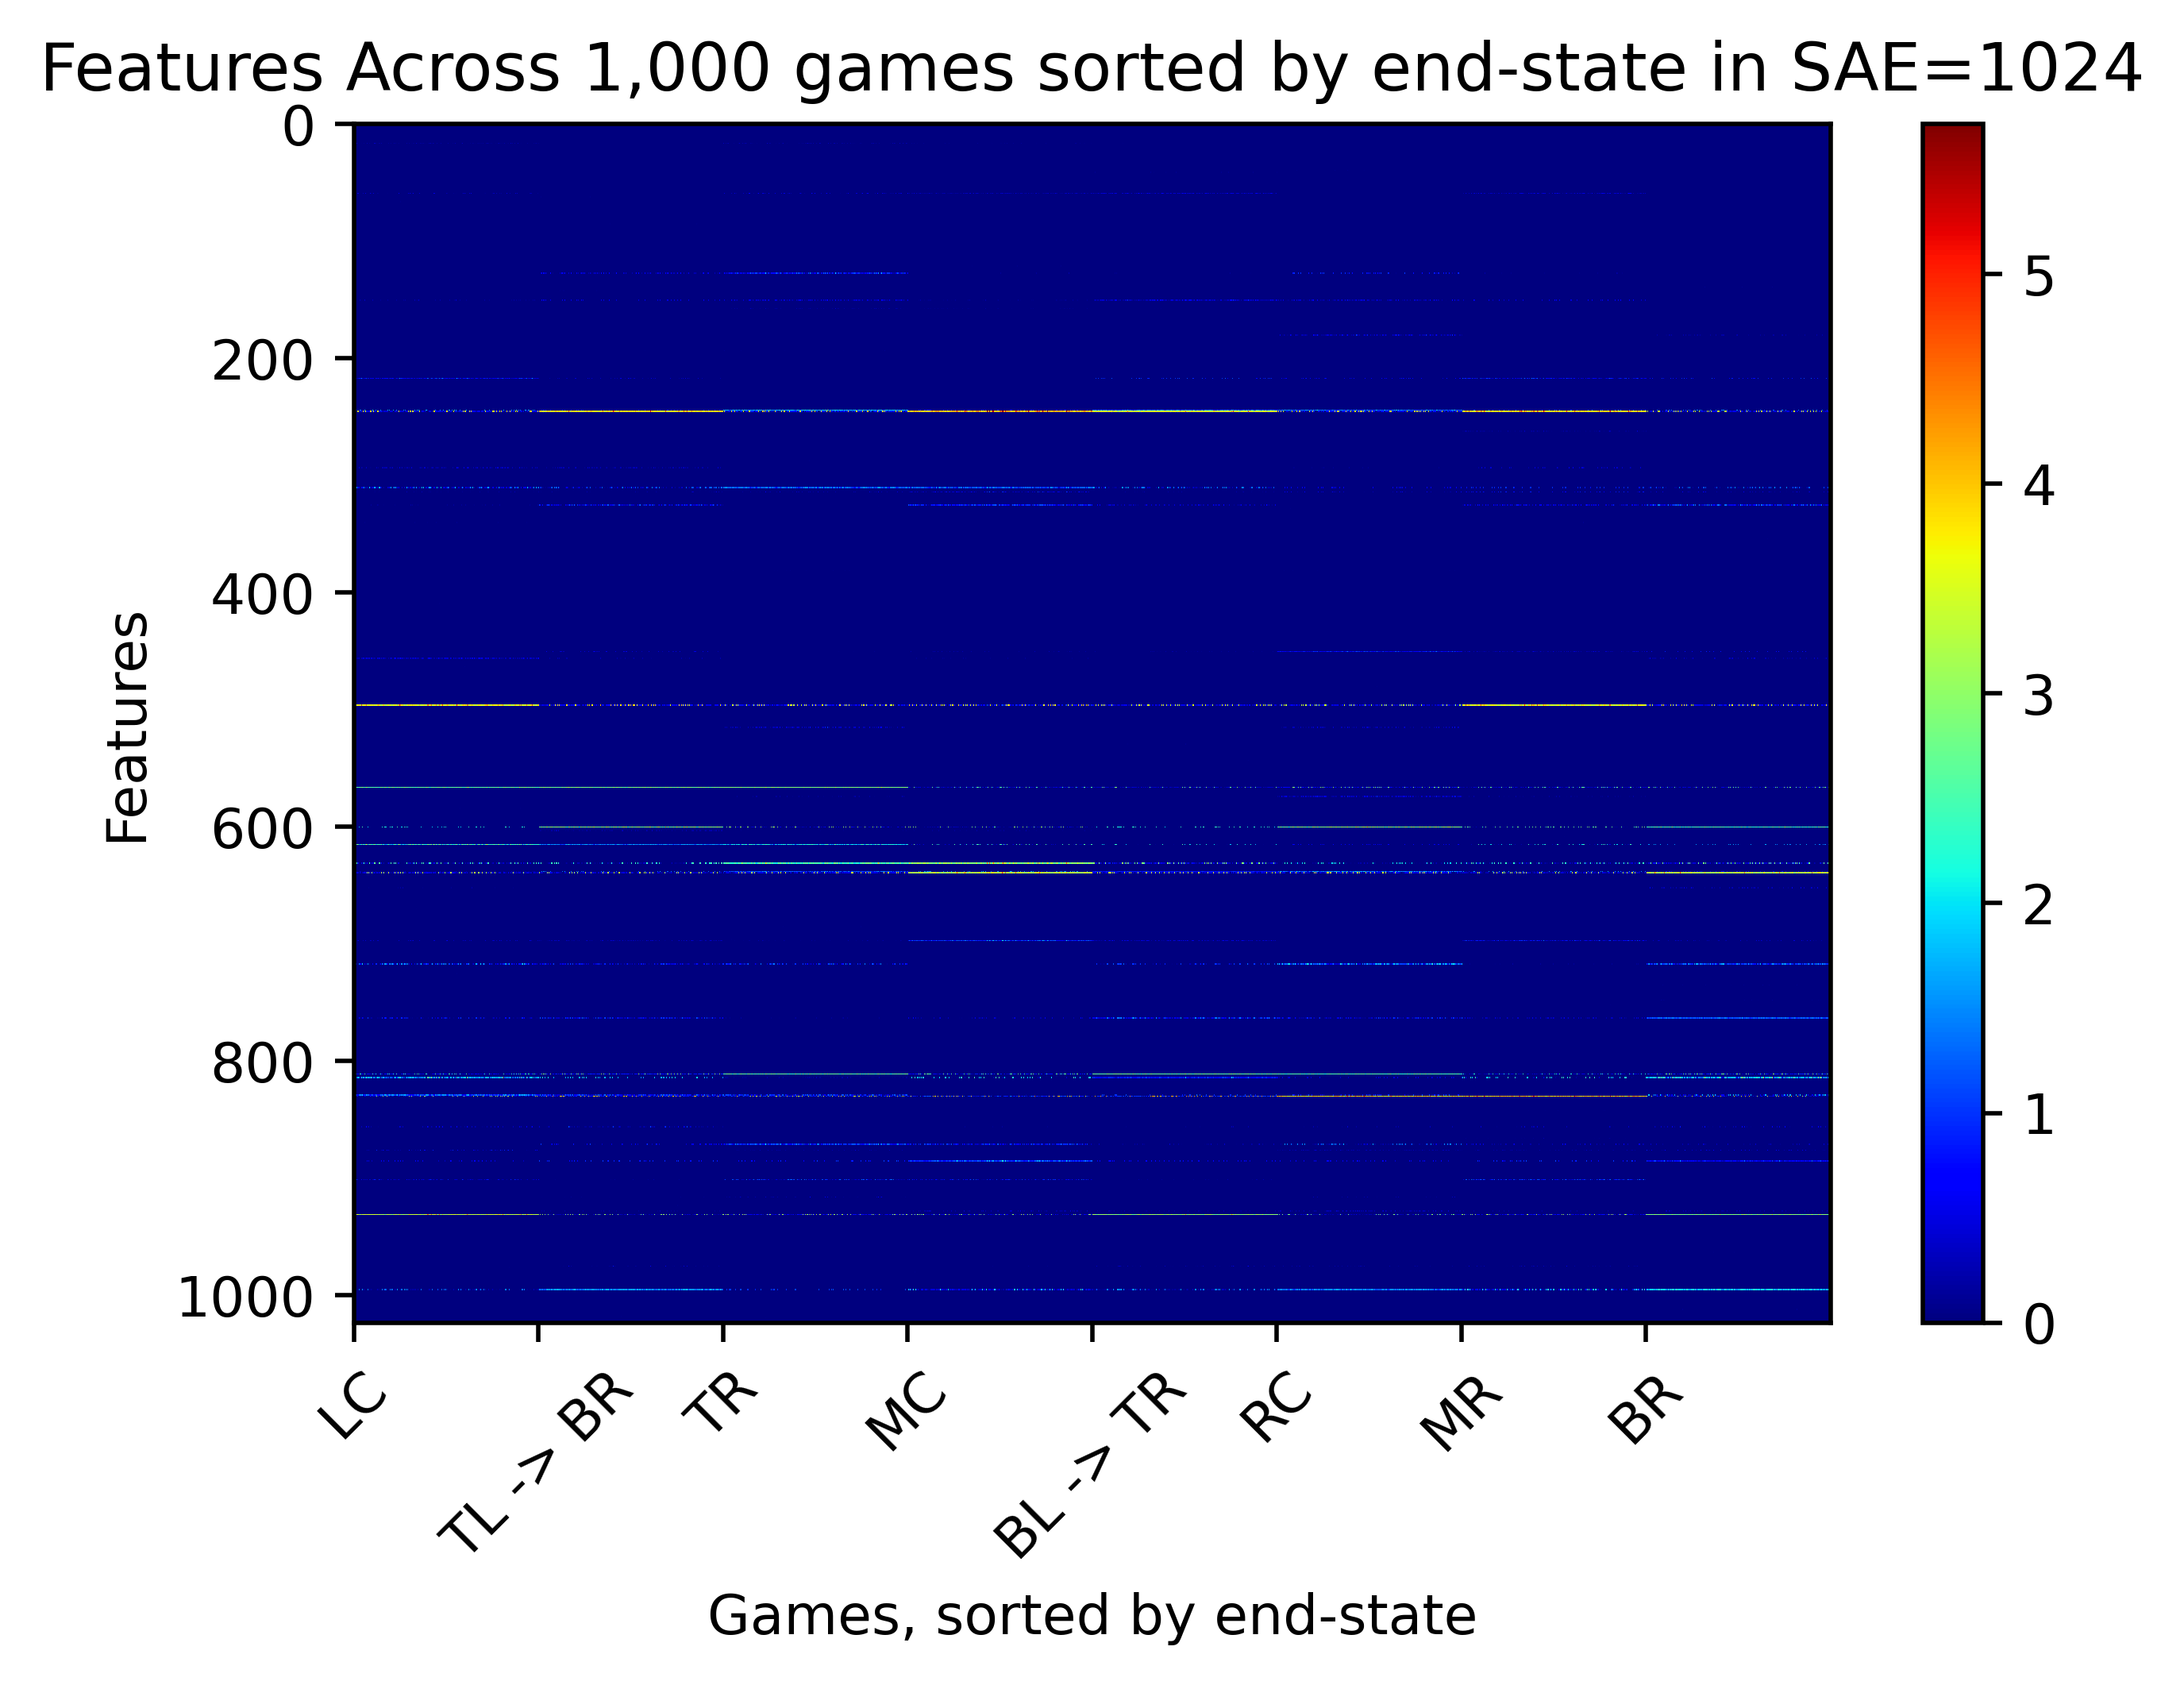

In [21]:
plt.figure(figsize=(10, 10))
# dpi
plt.figure(dpi=500)
plt.imshow(all_features, cmap="jet", aspect="auto", interpolation="none")
# colorbar
plt.colorbar()

plt.xlabel("Games, sorted by end-state")
plt.xticks(ticks=[0, 1000, 2000, 3000, 4000, 5000, 6000, 7000], labels=['LC', 'TL -> BR', 'TR', 'MC', 'BL -> TR', 'RC', 'MR', 'BR'])
#xtick 45 degree
plt.xticks(rotation=45);
plt.ylabel("Features")
# title
plt.title(
    "Features Across 1,000 games sorted by end-state in SAE=1024",
    fontsize=12,
)
plt.gcf().set_facecolor("white")